In [1]:
import sys
 
# setting path
sys.path.append('../')
import csv

from utils.dataloaders import MIDIEvalDataLoader
from utils.display import display_dicom
from dcm_anonymizers.utils import list_all_files

from pathlib import Path

In [2]:
root_data_dir = '/home/r079a/Desktop/de-identification/dataset'

loader = MIDIEvalDataLoader(
    rawimagespath=Path(root_data_dir, 'images/manifest-1617826555824'),
    deidimagespath=Path(root_data_dir, 'images-2/manifest-1617826161202'),
    uidsmappath=Path(root_data_dir, 'Pseudo-PHI-DICOM-Dataset-uid_crosswalk.csv'),
)

In [3]:
(rawdcm, metadata), (deiddcm, deiddcm_metadata) = loader.get_raw_n_deid_patient(0, include_metadata=True)

In [4]:
deiddcm_metadata

{'Series UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.334418705549879145080284996023',
 'Collection': 'Pseudo-PHI-DICOM-Data',
 '3rd Party Analysis': 'NO',
 'Data Description URI': 'https://doi.org/10.7937/s17zr072',
 'Subject ID': 'Pseudo-PHI-001',
 'Study UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.289834788775974734227766096544',
 'Study Description': 'XR CHEST AP PORTABLE',
 'Study Date': '06-26-2003',
 'Series Description': nan,
 'Manufacturer': 'FUJIFILM Corporation',
 'Modality': 'CR',
 'SOP Class Name': 'Computed Radiography Image Storage',
 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.1',
 'Number of Images': 1,
 'File Size': '7.54 MB',
 'File Location': './Pseudo-PHI-DICOM-Data/Pseudo-PHI-001/06-26-2003-NA-XR CHEST AP PORTABLE-96544/1002.000000-NA-96023',
 'Download Timestamp': '2024-06-03T18:24:56.679'}

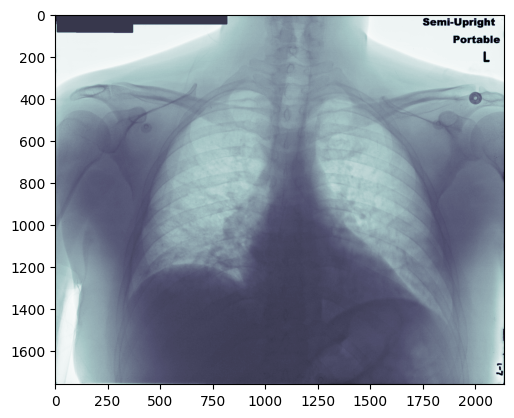

In [5]:
display_dicom(rawdcm[0])

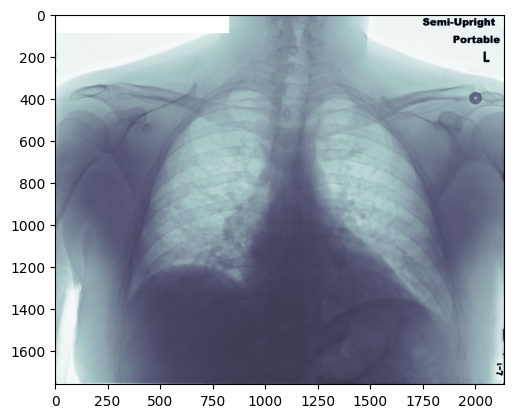

In [6]:
display_dicom(deiddcm[0])

In [7]:
# for element in rawdcm[0]:
#     if element.VR == 'OW' or element.VR == 'UI':
#         continue
        
#     thisval = element.value
#     deidval = ''
#     if element.tag in deiddcm[0]:
#         deidval = deiddcm[0][element.tag].value

#     if deidval != thisval:
#         print(element.tag, element.name, element.VR)
#         print(f"{thisval} --> {deidval}")

In [8]:
from dicomanonymizer.anonymizer import anonymize
from pathlib import Path
import os

In [9]:
rootdir = '/home/r079a/Desktop/de-identification/'

raw_img_path = Path(rootdir, 'dataset/images/manifest-1617826555824', metadata['File Location'])
output_path = Path(rootdir, 'dicom-output')

In [10]:
first_dcm_name = os.listdir(raw_img_path)[0]
first_dcm_name

'1-1.dcm'

In [11]:
anonymize(
    Path(raw_img_path, first_dcm_name), output_path, {}, True,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.10it/s]


In [12]:
from pydicom import dcmread
import pandas as pd

In [13]:
with open(Path(output_path, first_dcm_name), 'rb') as infile:
    ds = dcmread(infile)

In [14]:
tagvalues = []
for element in rawdcm[0]:
    if element.VR == 'OW':
        continue
    deidval = "Not available"
    if element.tag in deiddcm[0]:
        deidval = str(deiddcm[0][element.tag].value)
    dcmannonval = "Not available"
    if element.tag in ds:
        dcmannonval = str(ds[element.tag].value)
    changed = False
    # if str(element.value) != deidval or str(element.value) != dcmannonval:
    if str(element.value) != deidval:
        changed = True
    values_tuple = (str(element.tag), element.name, str(element.value), deidval, dcmannonval, changed)
    tagvalues.append(values_tuple)

In [15]:
valus_df = pd.DataFrame(tagvalues, columns =['Tag', 'Name', 'Raw Metadata', 'Ground Truth Anonimization', 'Dicom Anonymizer', 'Changed'])

In [16]:
pd.set_option('display.max_rows', 82)
valus_df[valus_df['Changed']]

,Tag,Name,Raw Metadata,Ground Truth Anonimization,Dicom Anonymizer,Changed
2,"(0008, 0018)",SOP Instance UID,2.25.112784503178059210578740147414000844278,1.3.6.1.4.1.14519.5.2.1.8700.9668.265811167095...,2.25.273857714557422940459855164386412801195,True
3,"(0008, 0020)",Study Date,20130713,20030626,00010101,True
4,"(0008, 0021)",Series Date,20130713,20030626,00010101,True
5,"(0008, 0022)",Acquisition Date,20130713,20030626,00010101,True
6,"(0008, 0023)",Content Date,20130713,20030626,00010101,True
11,"(0008, 0050)",Accession Number,20130714E864535,,,True
14,"(0008, 0080)",Institution Name,Scott Community Hospital,Not available,ANONYMIZED,True
15,"(0008, 0081)",Institution Address,"334 Michael Manor Sarahview, PA 56560",Not available,Not available,True
16,"(0008, 0090)",Referring Physician's Name,HUGHES^KATHLEEN,,,True
17,"(0008, 0092)",Referring Physician's Address,"0544 Green Inlet Jeffreyland, HI 66060",Not available,Not available,True


In [17]:
# targettag = (0x0018,0xa001)
# print(rawdcm[0][targettag].value)
# print(deiddcm[0][targettag].value)
# print(ds[targettag].value)

### Evaluate PS_3_3 Anonymizer

In [18]:
(rawdcm, metadata), (deiddcm, deiddcm_metadata) = loader.get_raw_n_deid_patient(13, include_metadata=True)

raw_dcm = rawdcm[0]
deid_dcm = deiddcm[0]

In [32]:
metadata

{'Series UID': '2.25.10951537720107263456062230200372018678',
 'Collection': 'Pseudo-PHI-DICOM-Data',
 '3rd Party Analysis': 'NO',
 'Data Description URI': 'https://doi.org/10.7937/s17zr072',
 'Subject ID': 6670427471,
 'Study UID': '2.25.98718517033909690319037131654713425398',
 'Study Description': 'FORFILE CT ABD ANDOR PEL - CD',
 'Study Date': '05-26-2000',
 'Series Description': 'NEPHRO  4.0  B40f  M0.4',
 'Manufacturer': 'SIEMENS',
 'Modality': 'CT',
 'SOP Class Name': 'CT Image Storage',
 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.2',
 'Number of Images': 107,
 'File Size': '56.49 MB',
 'File Location': './Pseudo-PHI-DICOM-Data/6670427471/05-26-2000-NA-FORFILE CT ABD ANDOR PEL - CD-25398/5.000000-NEPHRO  4.0  B40f  M0.4-18678',
 'Download Timestamp': '2024-06-03T18:21:40.612'}

In [19]:
deiddcm_metadata

{'Series UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.150726169700362683111630632617',
 'Collection': 'Pseudo-PHI-DICOM-Data',
 '3rd Party Analysis': 'NO',
 'Data Description URI': 'https://doi.org/10.7937/s17zr072',
 'Subject ID': 'Pseudo-PHI-010',
 'Study UID': '1.3.6.1.4.1.14519.5.2.1.8700.9668.272291997869536712755569210243',
 'Study Description': 'CT ABD ANDOR PEL - CD',
 'Study Date': '05-09-1990',
 'Series Description': 'NEPHRO  4.0  B40f  M0.4',
 'Manufacturer': 'SIEMENS',
 'Modality': 'CT',
 'SOP Class Name': 'CT Image Storage',
 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.2',
 'Number of Images': 107,
 'File Size': '56.53 MB',
 'File Location': './Pseudo-PHI-DICOM-Data/Pseudo-PHI-010/05-09-1990-NA-CT ABD ANDOR PEL - CD-10243/5.000000-NEPHRO  4.0  B40f  M0.4-32617',
 'Download Timestamp': '2024-06-03T18:26:01.044'}

In [20]:
anonymizer_output_path = Path(root_data_dir, 'anonymizer-output/Pseudo-PHI-DICOM-Data-2')

In [21]:
path_mapping_file = Path(anonymizer_output_path, 'mappings/path_mapping.csv')

def id_map_csv_to_dict(csvfile: str):
    id_map = {}
    with open(path_mapping_file, mode ='r')as file:
      mapping = csv.reader(file)
      for idx, lines in enumerate(mapping):
          if idx == 0:
              continue
          id_map[lines[0]] = lines[1]
    return id_map 

series_output_map = id_map_csv_to_dict(path_mapping_file)

def get_first_dcm_path_from_series(seriesUID: str):
    series_path = series_output_map.get(seriesUID, '')
    if series_path == "":
        print(f"No path found for given series id {seriesUID}")
        return
    full_series_path = anonymizer_output_path / 'data' / series_path
    alldcms = list_all_files(full_series_path)
    print(full_series_path)
    if len(alldcms) == 0:
        print(f"No dicom found for given series id {seriesUID}")
        return
    return alldcms[0]

In [22]:
deidentfied_dcm_path = get_first_dcm_path_from_series(metadata['Series UID'])
print(deidentfied_dcm_path)
with open(deidentfied_dcm_path, 'rb') as infile:
    deidentfied_dcm = dcmread(infile)

/home/r079a/Desktop/de-identification/dataset/anonymizer-output/Pseudo-PHI-DICOM-Data-2/data/Pseudo-PHI-010/1.2.826.0.1.3680043.8.498.79143975412520055270984203263227203639/1.2.826.0.1.3680043.8.498.97736883195878670271875414371087037518
/home/r079a/Desktop/de-identification/dataset/anonymizer-output/Pseudo-PHI-DICOM-Data-2/data/Pseudo-PHI-010/1.2.826.0.1.3680043.8.498.79143975412520055270984203263227203639/1.2.826.0.1.3680043.8.498.97736883195878670271875414371087037518/1-001.dcm


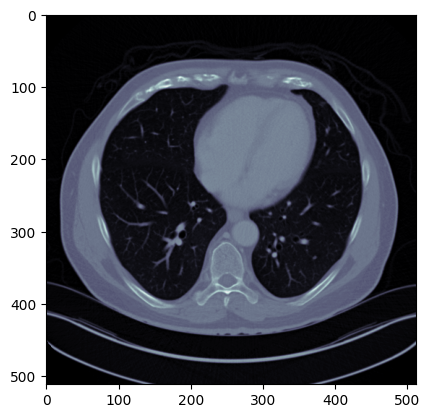

In [23]:
display_dicom(raw_dcm)

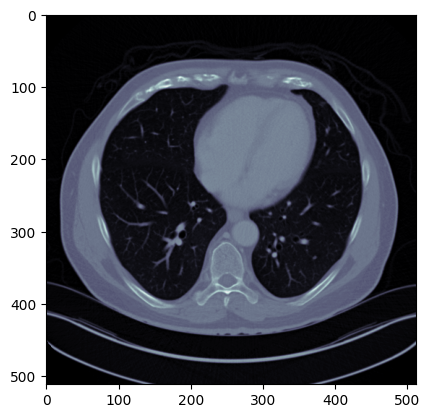

In [24]:
display_dicom(deid_dcm)

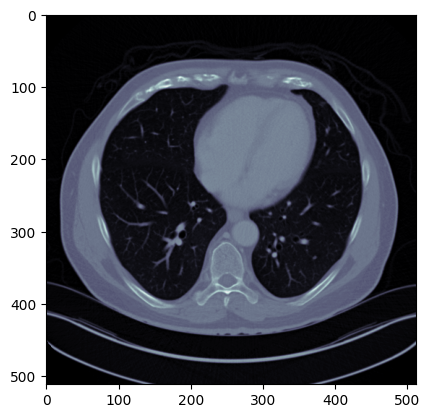

In [25]:
display_dicom(deidentfied_dcm)

In [26]:
# tagvalues = []
# for element in raw_dcm:
#     if element.VR == 'OW':
#         print(element.name)
#         continue
#     deidval = "Not available"
#     if element.tag in deid_dcm:
#         deidval = str(deid_dcm[element.tag].value)
#     dcmannonval = "Not available"
#     if element.tag in deidentfied_dcm:
#         dcmannonval = str(deidentfied_dcm[element.tag].value)
#     changed = False
#     if str(element.value) != deidval:
#         changed = True
#     values_tuple = (str(element.tag), element.name, str(element.value), deidval, dcmannonval, changed)
#     tagvalues.append(values_tuple)

In [27]:
import pydicom

In [28]:
tagvalues = []
    
def extract_tags(dcm, gt_ds, annon_ds):
    elements = dcm
    gt_elements = gt_ds
    annon_elements = annon_ds
    parent_tag = None
    
    if isinstance(dcm, pydicom.dataelem.DataElement):
        parent_tag = dcm.tag
        if len(dcm.value) == 0:
            return
        
        elements = dcm.value[0]
        gt_elements = None
        if gt_ds and len(gt_ds.value) > 0:
            gt_elements = gt_ds.value[0]
        
        annon_elements = None
        if annon_ds and len(annon_ds.value) > 0:
            annon_elements = annon_ds.value[0] if annon_ds else None
        
    for element in elements:
        deidelem = gt_elements.get(element.tag) if gt_elements else None
        dcmannonelem = annon_elements.get(element.tag) if annon_elements else None
        
        if element.VR == 'OW':
            continue
        elif element.VR == 'SQ':
            extract_tags(element, deidelem, dcmannonelem)
            continue
        # targettags.append(element.tag)
        
        deidval = "Not available"
        if deidelem:
            deidval = str(deidelem.value)
        dcmannonval = "Not available"
        if dcmannonelem:
            dcmannonval = str(dcmannonelem.value)
        changed = False
        if dcmannonval != deidval:
            changed = True

        element_tag_str = str(element.tag)
        if parent_tag:
            element_tag_str = f"{str(parent_tag)} - {str(element.tag)}"
        values_tuple = (element_tag_str, element.VR, element.name, str(element.value), deidval, dcmannonval, changed)
        tagvalues.append(values_tuple)

extract_tags(raw_dcm, deid_dcm, deidentfied_dcm)

In [29]:
valus_df = pd.DataFrame(tagvalues, columns =['Tag', 'VR', 'Name', 'Raw Metadata', 'Ground Truth Anonimization', 'PS 3.3 Anonymizer', 'Changed'])

In [30]:
changed_df = valus_df[valus_df['Changed']]
changed_df

,Tag,VR,Name,Raw Metadata,Ground Truth Anonimization,PS 3.3 Anonymizer,Changed
3,"(0008, 0018)",UI,SOP Instance UID,2.25.192064249168232522825882814377465855478,1.3.6.1.4.1.14519.5.2.1.8700.9668.216701533061...,1.2.826.0.1.3680043.8.498.14752610215110319091...,True
4,"(0008, 0020)",DA,Study Date,20000526,19900509,20000923,True
5,"(0008, 0021)",DA,Series Date,20000526,19900509,20000923,True
6,"(0008, 0022)",DA,Acquisition Date,20000526,19900509,20000923,True
7,"(0008, 0023)",DA,Content Date,20000526,19900509,20000923,True
8,"(0008, 002a)",DT,Acquisition DateTime,20000526125439.765000,19900509,20000923125439,True
21,"(0008, 1030)",LO,Study Description,FORFILE CT ABD AND/OR PEL - CD,CT ABD AND/OR PEL - CD,FORFILE CT ABD AND/OR PEL - CD,True
25,"(0008, 1032) - (0008, 0104)",LO,Code Meaning,FORFILE CT ABD AND/OR PEL - CD,CT ABD AND/OR PEL - CD,FORFILE CT ABD AND/OR PEL - CD,True
30,"(0008, 1110) - (0008, 1150)",UI,Referenced SOP Class UID,1.2.840.10008.3.1.2.3.1,1.2.840.10008.3.1.2.3.1,2.25.262253877913583911000247039857119812228,True
31,"(0008, 1110) - (0008, 1155)",UI,Referenced SOP Instance UID,2.25.98465855254525200775877816255333907958,1.3.6.1.4.1.14519.5.2.1.8700.9668.191160684599...,2.25.115278987621680142062578690224088854113,True


In [31]:
n_mismatched = 0
mismatched_tags = []

for index, row in valus_df.iterrows():
    gt_val = row['Ground Truth Anonimization']
    target_val = row['PS 3.3 Anonymizer']

    if gt_val != target_val:
        if row['VR'] == 'UI' and not (gt_val == "" or target_val == ""):
            continue
        elif row['VR'] in ('DA', 'DT', 'TM') and not (gt_val == "" or target_val == ""):
            if len(gt_val) != len(target_val):
                pass
            continue
        elif row['Tag'] in ('(0010, 0010)', '(0010, 0020)'):
            continue
        n_mismatched += 1
        mismatched_tags.append(row['Name'])

print(n_mismatched)
print(mismatched_tags)

11
['Study Description', 'Code Meaning', 'Derivation Description', 'Private Creator', 'Private tag data', 'Date of Last Calibration', 'Time of Last Calibration', 'Image Comments', 'Private Creator', 'Private Creator', 'Private Creator']
